# FDL 2019 - Floods

Load in any libraries and datasets needed

In [1]:
gp:.p.import[`geopandas]
\l ml/ml.q 
\l ml/init.q


avs:.p.import[`sklearn.metrics]`:average_precision_score
mattab:{flip value flip x}
svc:.p.import[`sklearn.svm]`:SVC
array:.p.import[`numpy]`:array

Datasets include

Max height per day per stream

NLCD(imperveous) dataset collected in 2006,2011,2016

Flood warned levels from NOAA, based on lat,long

stream gage info i.e location,state, codes etc

basin attributes at each stream gage

In [2]:
maxht:("SDF";enlist ",") 0:`:data/maxht.csv

raindata:("DSSIFFSS";enlist ",") 0:`:data/raindata.csv

nlcd06:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2006.csv 
nlcd11:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2011.csv 
nlcd16:("S",(5#"F"),"SFFSFSFFFFSFSSFSSFFFSFFSFF";enlist ",") 0:`:data/snap_sampled_imp_nlcd_2016.csv 

warnings:gp[`:read_file]["data/national_shapefile_obs.shp"]
warnings:.ml.df2tab[warnings]

gages:("SSSSFFSSIFFFFFFFFSSISSSSFF";enlist ",") 0:`:data/usgs_gage_subset.csv

basin:("S",242#"F";enlist ",") 0:`:data/gages_with_basin_attr.csv

Linking the stream gages with corresponding rain gages based on nearest neighbour (lat,long) and date (per month). 

In [3]:
maxht:delete from maxht where height<0

strmonth:0!select by site_no,"m"$date from maxht

gages[`site_no]:`${$[7=count x;"0",x;x]}each string each gages[`site_no] /pad with 0 if len site=7

show httab:strmonth ij `site_no xkey select site_no,dec_lat_va,dec_long_v from gages

site_no  date    height dec_lat_va dec_long_v
---------------------------------------------
01200000 2009.07 3.8    41.65876   -73.52868 
01200000 2009.08 1.82   41.65876   -73.52868 
01200000 2009.09 1.29   41.65876   -73.52868 
01200000 2009.10 2.04   41.65876   -73.52868 
01200000 2009.11 1.71   41.65876   -73.52868 
01200000 2009.12 4.17   41.65876   -73.52868 
01200000 2010.01 2.8    41.65876   -73.52868 
01200000 2010.02 4.35   41.65876   -73.52868 
01200000 2010.03 6.17   41.65876   -73.52868 
01200000 2010.04 1.96   41.65876   -73.52868 
01200000 2010.05 1.22   41.65876   -73.52868 
01200000 2010.06 0.91   41.65876   -73.52868 
01200000 2010.07 0.76   41.65876   -73.52868 
01200000 2010.08 0.83   41.65876   -73.52868 
01200000 2010.09 1.5    41.65876   -73.52868 
01200000 2010.10 1.63   41.65876   -73.52868 
01200000 2010.11 1.8    41.65876   -73.52868 
01200000 2010.12 2.05   41.65876   -73.52868 
01200000 2011.01 2.15   41.65876   -73.52868 
01200000 2011.02 3.75   41.65876  

In [4]:
/take "A" out of any float
raindata[`precip]:{$[1= count raze x;0n;"F"$raze[x]except "A"]} each string each exec precip from raindata 
     
/take out any null precip values (might come back to backfill/forward fill/moving average later)
/show raindata:delete ghnc,coras from select from raindata where not 0n=precip 
nullvals:0!select i,reverse fills reverse fills precip by uid from raindata
rainnull:update precip:(raze nullvals[`precip]) from raindata where i in raze nullvals[`x]
nullvals2:0!select i,reverse fills reverse fills precip by uid from rainnull
show raindata:update precip:(raze nullvals[`precip]) from raindata where i in raze nullvals2[`x]

date       precip elv    uid   long      lat      ghnc        coras      
-------------------------------------------------------------------------
2009.07.01 0      None   82630 -96.5204  40.4914  US10gage044 0gage044   
2009.07.01 0      1345.0 62206 -96.5009  40.5529  US10lanc014 0lanc014   
2009.07.01 0.24   1323.0 40728 -96.5102  40.452   250001      USC00250001
2009.07.01 0.24   4670.0 12790 -103.7347 42.4244  250030      USC00250030
2009.07.01 0      None   30096 -100.0112 42.3171  US10brow009 0brow009   
2009.07.01 0      None   30095 -100.061  42.3248  US10brow008 0brow008   
2009.07.01 0      2510.0 12799 -99.8555  42.5522  250050      USC00250050
2009.07.01 0      1883.0 61884 -97.9951  41.6402  US10boon005 0boon005   
2009.07.01 0      1814.0 61886 -97.8945  41.6685  US10boon009 0boon009   
2009.07.01 0      1801.0 61887 -98.1166  41.6689  US10boon010 0boon010   
2009.07.01 0      1795.0 12683 -98.0083  41.6854  250070      USC00250070
2009.07.01 0      None   30441 -97.231

Get stats on each rain gage per month,uid (id of raingage)

In [5]:
show rainmonth:0!select distinct lat,distinct long,sumpr:sum precip,
    maxpre:max precip,minpre:min precip,avgpre:avg precip,varpre:var precip by uid,"m"$date from raindata

uid date    lat     long     sumpr maxpre minpre avgpre     varpre    
----------------------------------------------------------------------
81  2009.07 40.6005 -98.4258 7.88  4      0      0.2541935  0.6002695 
81  2009.08 40.6005 -98.4258 8.92  4      0      0.2877419  0.6410626 
81  2009.09 40.6005 -98.4258 5.99  2.16   0      0.1996667  0.2644566 
81  2009.10 40.6005 -98.4258 5.15  1.44   0      0.166129   0.1429011 
81  2009.11 40.6005 -98.4258 6.96  3.15   0      0.232      0.4444093 
81  2009.12 40.6005 -98.4258 2.65  1.3    0      0.08548387 0.07731509
81  2010.01 40.6005 -98.4258 7.42  2.02   0      0.2393548  0.2403867 
81  2010.02 40.6005 -98.4258 2.76  0.95   0      0.09857143 0.05606224
81  2010.03 40.6005 -98.4258 3.82  1.5    0      0.1232258  0.09391863
81  2010.04 40.6005 -98.4258 1.74  0.92   0      0.058      0.03110267
81  2010.05 40.6005 -98.4258 1.55  1.31   0      0.05       0.05336774
81  2010.06 40.6005 -98.4258 5.78  2.04   0      0.1926667  0.2208929 
81  20

Get the nearest neighbour of each stream gage station using the clustering library in the ml toolkit

In [6]:
/get lat long of rain gages
latlonr:0!select raze distinct lat,raze distinct long by uid from raindata

/build tree of all lat longs 
tab:.ml.clust.kd.buildtree[latlongs:gages[`dec_lat_va`dec_long_v],'raze each latlonr[`lat`long];2]

/use narest neighbour function
/the third input groups all the stream gage lat,long together so that it won't match with any of them
/(will later amend the function so that you only have to give the rain gage lat longs so that calcs are faster)


clusts:.ml.clust.kd.i.nns[;tab;(count[latlonr]#0),count[gages]#1;latl:flip latlongs;`edist]
    each count[latlonr]+til count gages  /add on count latlon because that's the index you;re starting at 

Get the id (uid) of each stream gages nearest neighbour.

In [7]:
/Nearest distance (nd) is also added so that threshold can be included at a later stage if needed
nntab:flip `uid`nd`site_no!(latlonr[`uid]clusts[;0];clusts[;1];gages[`site_no])

htdata:delete height from httab ij `site_no xkey nntab

show raingageall:htdata lj `date`uid xkey rainmonth

site_no  date    dec_lat_va dec_long_v uid   nd         lat     long     sump..
-----------------------------------------------------------------------------..
01200000 2009.07 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 7   ..
01200000 2009.08 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.38..
01200000 2009.09 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.99..
01200000 2009.10 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.9..
01200000 2009.11 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.25..
01200000 2009.12 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.2..
01200000 2010.01 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.59..
01200000 2010.02 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.9 ..
01200000 2010.03 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.79..
01200000 2010.04 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 2.67..
01200000 2010.05 41.65876   -73.52868  5

When linking by date, not all stream gages and nearest rain gage run for the same period of time so there is a lot of gaps left in the dataset, so additional nn based on time constraints must be added

In [8]:
/group uid by date 
uidmonth:0!select uid by date from rainmonth

/get the rows that havent been joined by null values
nullv:0!select site_no,cs:count site_no by date from nonjoin:select from raingageall where sumpr=0n

/get rain uids corresponding to the missing days
ruv:latlonr[`uid]?{exec uid from uidmonth where date=x}each nullv[`date]

/get indices per day of what sites have to be recalculated
gsv:count[latlonr]+gages[`site_no]?/:nullv[`site_no]

/join index to the nearest neightbours of missing data (must be a more efficient way than doin all these calcs?)
newnn:raze {.ml.clust.kd.i.nns[;tab;@[count[latl]#0;x;+;1];latl;`edist]each y}'[ruv;gsv]

Join updated nntable with old

In [9]:
updnntab:flip `uid`nd`site_no`date!(latlonr[`uid]newnn[;0];newnn[;1];raze nullv[`site_no];
    raze (nullv[`cs])#'nullv[`date])

updhtdata:(select site_no,date,dec_lat_va,dec_long_v from nonjoin) ij `site_no`date xkey updnntab
                                       
show allraind:(select from raingageall where not sumpr=0n),updhtdata ij `date`uid xkey rainmonth

site_no  date    dec_lat_va dec_long_v uid   nd         lat     long     sump..
-----------------------------------------------------------------------------..
01200000 2009.07 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 7   ..
01200000 2009.08 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.38..
01200000 2009.09 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.99..
01200000 2009.10 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.9..
01200000 2009.11 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.25..
01200000 2009.12 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.2..
01200000 2010.01 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.59..
01200000 2010.02 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.9 ..
01200000 2010.03 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.79..
01200000 2010.04 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 2.67..
01200000 2010.05 41.65876   -73.52868  5

### Basin Characteristics

Take out columns that depend on the date like 09,10,11. Link it with previous table

In [10]:
cols09:where (count each ss[;"2006"]each string each cols basin)<>0
cols10:where (count each ss[;"2010"]each string each cols basin)<>0
cols11:where (count each ss[;"2011"]each string each cols basin)<>0

In [11]:
constcols:(til count[cols basin]) except raze 
    {where (count each ss[;x]each string each cols basin)<>0}each ("2009";"2010";"2011")

basinupd:flip (cols basin)[constcols]!basin[(cols basin)[constcols]]

show joinedtab:allraind ij `site_no xkey basinupd

site_no  date    dec_lat_va dec_long_v uid   nd         lat     long     sump..
-----------------------------------------------------------------------------..
01200000 2009.07 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 7   ..
01200000 2009.08 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.38..
01200000 2009.09 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.99..
01200000 2009.10 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.9..
01200000 2009.11 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.25..
01200000 2009.12 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.2..
01200000 2010.01 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.59..
01200000 2010.02 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.9 ..
01200000 2010.03 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.79..
01200000 2010.04 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 2.67..
01200000 2010.05 41.65876   -73.52868  5

### NLCD Dataset

Join NLCD (impervious info) to each station based on date. Only 3 datasets so link back in time

Only pick columns with some variance between stations

In [12]:
nlcd06:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:6 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2006 from nlcd06
nlcd11:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:11 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2011 from nlcd11
nlcd16:update site_no:`${$[7=count x;"0",x;x]}each string each site_no,year:16 from select
 site_no:SOURCE_FEA,INTPTLAT,INTPTLON,Measure,REACHCODE,distance,imp:imp_nlcd_2016 from nlcd16

In [13]:
stryear:{$[x<2011;6;x<2016;11;16]}each `year$joinedtab[`date]

merged:update year:stryear from joinedtab

newjoinedtab:merged ij `site_no xkey (nlcd06,nlcd11,nlcd16)

# Getting the Target Data

Get the count per month that a station goes over a flood level, broken up into 4 categories-Action,Flood,Moderate and Major

In [14]:
/Some gages have no threshold values so had to delete them from dataset
dela:first asc exec i by Action from warnings
delmj:first 1_asc exec i by Major from warnings
delmd:first 2_asc exec i by Moderate from warnings
delfl:first 2_asc exec i by Flood from warnings

warning:update nn: i from select from warnings where not i in distinct (dela,delmj,delmd,delfl)

Join based on nn

In [15]:
tabw:.ml.clust.kd.buildtree[warnlatl:gages[`dec_lat_va`dec_long_v],'"F"$'string each warning[`Latitude`Longitude];2]

nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gages]#1;flip warnlatl;`edist
    ]each count[warning]+til count gages

In [16]:
joins:flip `nn`ndw`site_no!(nnwarn[;0];nnwarn[;1];gages[`site_no])

floodlvl:(maxht ij `site_no xkey joins) lj `nn xkey warning

floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

floodlvl[`site_no]:`${$[7=count x;"0",x;x]}each string each floodlvl[`site_no] /pad with 0 if len site=7

In [17]:
show target:0!select distinct Action,distinct Flood,distinct Moderate,distinct Major,no_Action:count where height>Action
 ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where height>Major by site_no
    ,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 17     19    22       24    0         0        0      0       
01200000 2009.08 17     19    22       24    0         0        0      0       
01200000 2009.09 17     19    22       24    0         0        0      0       
01200000 2009.10 17     19    22       24    0         0        0      0       
01200000 2009.11 17     19    22       24    0         0        0      0       
01200000 2009.12 17     19    22       24    0         0        0      0       
01200000 2010.01 17     19    22       24    0         0        0      0       
01200000 2010.02 17     19    22       24    0         0        0      0       
01200000 2010.03 17     19    22       24    0         0        0      0       
01200000 2010.04 17     19    22       24    0         0        0      0       
01200000 2010.05 17     19    22       2

In [18]:
show allmerged:newjoinedtab ij `site_no`date xkey target


site_no  date    dec_lat_va dec_long_v uid   nd         lat     long     sump..
-----------------------------------------------------------------------------..
01200000 2009.07 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 7   ..
01200000 2009.08 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.38..
01200000 2009.09 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.99..
01200000 2009.10 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.9..
01200000 2009.11 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.25..
01200000 2009.12 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.2..
01200000 2010.01 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.59..
01200000 2010.02 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.9 ..
01200000 2010.03 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.79..
01200000 2010.04 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 2.67..
01200000 2010.05 41.65876   -73.52868  5

In [19]:
/Tidy up some column types
allmerged[`site_no]:"F"$string each allmerged[`site_no]
allmerged[`lat`long]:raze each "F"$'string each allmerged[`lat`long]
allmerged[`Action]:raze allmerged[`Action]
allmerged[`Flood]:raze allmerged[`Flood]
allmerged[`Moderate]:raze allmerged[`Moderate]
allmerged[`Major]:raze allmerged[`Major]

In [20]:
allmerged:update month:`mm$date from allmerged

### Machine Learning Model

In [21]:
tgts:select site_no,no_Action,no_Flood,no_Mod,no_Major from allmerged
allmerged:delete no_Action,no_Flood,no_Mod,no_Major from allmerged

In [22]:
show tabreduced:`site_no`date xkey .ml.dropconstant[.ml.filltab[allmerged;`site_no;`date;::]]

site_no date   | dec_lat_va dec_long_v uid   nd         lat     long     sump..
---------------| ------------------------------------------------------------..
1200000 2009.07| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 7   ..
1200000 2009.08| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.38..
1200000 2009.09| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.99..
1200000 2009.10| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.9..
1200000 2009.11| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.25..
1200000 2009.12| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 10.2..
1200000 2010.01| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 5.59..
1200000 2010.02| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 3.9 ..
1200000 2010.03| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 4.79..
1200000 2010.04| 41.65876   -73.52868  56792 0.01061508 42.8526 -78.7034 2.67..
1200000 2010.05| 41.65876   -73.52868  5

Standardised scaling is preformed on some of the columns

In [23]:
stdtab:.ml.stdscaler[delete dec_lat_va,dec_long_v,uid,nd,lat,long from value tabreduced]
newtab:`site_no`date xkey (select site_no,date,dec_lat_va,dec_long_v,uid,nd,lat,long from 0!tabreduced),'stdtab

The train and test set are strictly divided so that each station is either in train or test so that there is no data leakage

In [24]:
tstsplt:250#distinct key[newtab][`site_no]
trainsplt:250_distinct key[newtab][`site_no]

In [25]:
xtrain:value select from newtab where site_no in trainsplt
xtest:value select from newtab where site_no in tstsplt

In [26]:
/predict for  Moderate floods
ytrain:(exec no_Flood from tgts where site_no in trainsplt)>0
ytest:(exec no_Flood from tgts where site_no in tstsplt)>0


In [27]:
/backfilling per site doesn't work as nulls for all site, will look more into that
xtr:(mattab xtrain)[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]
ytr:ytrain[(til count[mattab xtrain]) except where 0<>{count where x=0n}each mattab xtrain]

### Baseline Random Forest

In [28]:
clf:.p.import[`sklearn.ensemble][`:RandomForestClassifier][`n_estimators pykw 200;`random_state pykw 1]
clf[`:fit][xtr;ytr]`;
pred1:clf[`:predict][mattab xtest]`

In [29]:
.ml.classreport[ytest;pred1]

class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9816764 0.9107423 0.9448799 24883  
1        | 0.1587121 0.4976247 0.2406663 842    
avg/total| 0.5701943 0.7041835 0.5927731 25725  


In [30]:
show acc:(count where pred1=ytest)%count[ytest]

0.8972206


0| 22662 2221
1| 423   419 


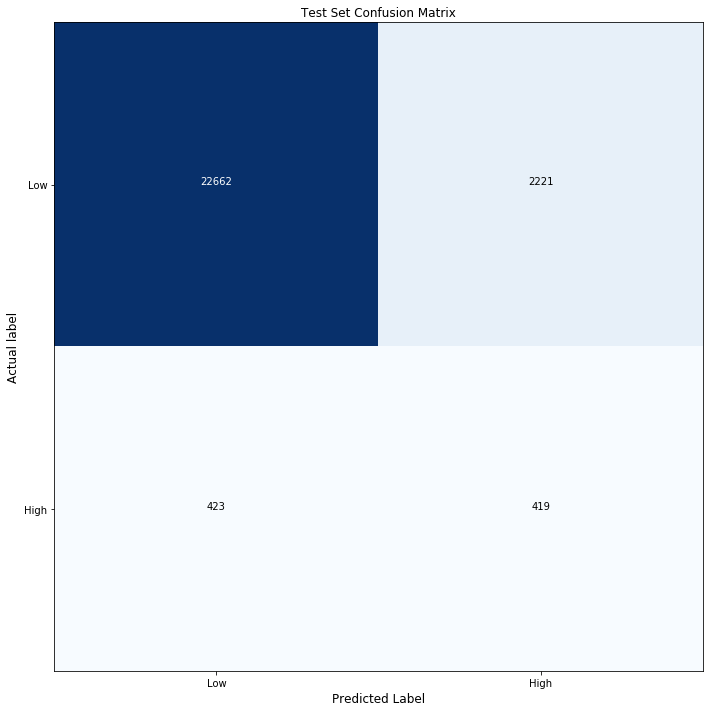

In [31]:
\l ml/fresh/notebooks/graphics.q
show cnfM:.ml.confmat[ytest;pred1]
conf:.ml.confdict[ytest;pred1;1b]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]

In [32]:
show meanclassavg:avg (conf[`tp]%(sum conf[`tp`fn]);conf[`tn]%(sum conf[`tn`fp]))

0.7041835


### Neural Net

Import models needed for Neural Net

In [33]:
sequential:    .p.import[`keras.models]`:Sequential
dense:         .p.import[`keras.layers]`:Dense
normalization: .p.import[`keras.layers]`:BatchNormalization
pylist:        .p.import[`builtins]`:list
models:        .p.import[`keras]`:Model
inp:.p.import[`keras.layers]`:Input
km:.p.import[`keras_metrics]
plt:.p.import[`matplotlib]`:pyplot


Using TensorFlow backend.


In [34]:
inputl:inp[`shape pykw enlist 177]
output:dense[1;`activation pykw `softmax][inputl]
modl:models[`inputs pykw inputl;`outputs pykw output]
modl[`:compile][`optimizer pykw "adam";`loss pykw "binary_crossentropy";`metrics pykw (km[`:binary_precision][]`;km[`:binary_recall][]`)]

res:modl[`:fit][array[xtr];ytr;`batch_size pykw 100;`verbose pykw 1;`epochs pykw 100];


{[f;x]embedPy[f;x]}[foreign]enlist


2019-07-29 06:40:18.788455: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-07-29 06:40:18.801844: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-07-29 06:40:18.805443: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa67e840 executing computations on platform Host. Devices:
2019-07-29 06:40:18.805534: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-07-29 06:40:18.967483: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

Epoch 1/100
42511/42511 [==============================] - ETA: 1s - loss: 13.1038 - precision: 0.1781 - recall: 1.0000  - ETA: 2s - loss: 13.0536 - precision: 0.1812 - recall: 1.00 - ETA: 1s - loss: 13.1541 - precision: 0.1749 - recall: 1.000 - ETA: 1s - loss: 13.1178 - precision: 0.1772 - recall: 1.000 - ETA: 0s - loss: 13.0892 - precision: 0.1790 - recall: 1.000 - ETA: 0s - loss: 13.0644 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0799 - precision: 0.1795 - recall: 1.000 - ETA: 0s - loss: 13.0504 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0447 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0509 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0431 - precision: 0.1819 - recall: 1.000 - ETA: 0s - loss: 13.0403 - precision: 0.1820 - recall: 1.000 - ETA: 0s - loss: 13.0420 - precision: 0.1819 - recall: 1.000 - ETA: 0s - loss: 13.0447 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0435 - precision: 0.1818 - recall: 1.000 - 1s 24us/st

42511/42511 [==============================] - ETA: 0s - loss: 13.0125 - precision: 0.1838 - recall: 1.000 - ETA: 1s - loss: 13.0044 - precision: 0.1843 - recall: 1.000 - ETA: 0s - loss: 13.0839 - precision: 0.1793 - recall: 1.000 - ETA: 0s - loss: 13.1208 - precision: 0.1770 - recall: 1.000 - ETA: 0s - loss: 13.1073 - precision: 0.1778 - recall: 1.000 - ETA: 0s - loss: 13.0341 - precision: 0.1824 - recall: 1.000 - ETA: 0s - loss: 13.0274 - precision: 0.1828 - recall: 1.000 - ETA: 0s - loss: 12.9925 - precision: 0.1850 - recall: 1.000 - ETA: 0s - loss: 13.0312 - precision: 0.1825 - recall: 1.000 - ETA: 0s - loss: 13.0125 - precision: 0.1838 - recall: 1.000 - ETA: 0s - loss: 13.0135 - precision: 0.1837 - recall: 1.000 - ETA: 0s - loss: 13.0300 - precision: 0.1827 - recall: 1.000 - ETA: 0s - loss: 13.0167 - precision: 0.1835 - recall: 1.000 - ETA: 0s - loss: 13.0309 - precision: 0.1826 - recall: 1.000 - ETA: 0s - loss: 13.0290 - precision: 0.1827 - recall: 1.000 - ETA: 0s - loss: 13.0330

42511/42511 [==============================] - ETA: 0s - loss: 13.0189 - precision: 0.1834 - recall: 1.0000- ETA: 1s - loss: 12.9968 - precision: 0.1848 - recall: 1.000 - ETA: 1s - loss: 13.1078 - precision: 0.1778 - recall: 1.000 - ETA: 0s - loss: 13.0682 - precision: 0.1803 - recall: 1.000 - ETA: 0s - loss: 13.0615 - precision: 0.1807 - recall: 1.000 - ETA: 0s - loss: 13.0703 - precision: 0.1802 - recall: 1.000 - ETA: 0s - loss: 13.0648 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0424 - precision: 0.1819 - recall: 1.000 - ETA: 0s - loss: 13.0143 - precision: 0.1837 - recall: 1.000 - ETA: 0s - loss: 13.0126 - precision: 0.1838 - recall: 1.000 - ETA: 0s - loss: 13.0078 - precision: 0.1835 - recall: 1.00 - ETA: 0s - loss: 13.0286 - precision: 0.1828 - recall: 1.000 - ETA: 0s - loss: 13.0392 - precision: 0.1821 - recall: 1.000 - ETA: 0s - loss: 13.0448 - precision: 0.1818 - recall: 1.000 - 1s 18us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000
Epoch 13/100
42511/4

42511/42511 [==============================] - 1s 25us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 1s - loss: 12.9930 - precision: 0.1850 - recall: 1.000 - ETA: 1s - loss: 12.8974 - precision: 0.1910 - recall: 1.000 - ETA: 0s - loss: 12.9809 - precision: 0.1858 - recall: 1.000 - ETA: 0s - loss: 13.0203 - precision: 0.1833 - recall: 1.000 - ETA: 0s - loss: 13.0337 - precision: 0.1824 - recall: 1.000 - ETA: 0s - loss: 13.0120 - precision: 0.1838 - recall: 1.000 - ETA: 0s - loss: 13.0079 - precision: 0.1841 - recall: 1.000 - ETA: 0s - loss: 12.9986 - precision: 0.1847 - recall: 1.00 - ETA: 0s - loss: 13.0371 - precision: 0.1822 - recall: 1.000 - ETA: 0s - loss: 13.0503 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0592 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.0533 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0616 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.0467 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0463 

42511/42511 [==============================] - ETA: 0s - loss: 13.0265 - precision: 0.1829 - recall: 1.0000- ETA: 0s - loss: 13.1243 - precision: 0.1768 - recall: 1.000 - ETA: 0s - loss: 13.0755 - precision: 0.1798 - recall: 1.00 - ETA: 0s - loss: 13.1095 - precision: 0.1762 - recall: 1.000 - ETA: 0s - loss: 13.0915 - precision: 0.1788 - recall: 1.000 - ETA: 0s - loss: 13.0558 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0526 - precision: 0.1824 - recall: 1.00 - ETA: 0s - loss: 13.0492 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0351 - precision: 0.1824 - recall: 1.000 - ETA: 0s - loss: 13.0380 - precision: 0.1822 - recall: 1.00 - ETA: 0s - loss: 13.0343 - precision: 0.1824 - recall: 1.000 - ETA: 0s - loss: 13.0444 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0327 - precision: 0.1825 - recall: 1.000 - ETA: 0s - loss: 13.0413 - precision: 0.1820 - recall: 1.000 - 1s 20us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000
Epoch 27/100
42511/425

42511/42511 [==============================] - ETA: 0s - loss: 13.0251 - precision: 0.1829 - recall: 1.000 - ETA: 0s - loss: 13.0728 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.0927 - precision: 0.1787 - recall: 1.000 - ETA: 0s - loss: 13.0247 - precision: 0.1830 - recall: 1.000 - ETA: 0s - loss: 13.0070 - precision: 0.1841 - recall: 1.000 - ETA: 0s - loss: 13.0138 - precision: 0.1837 - recall: 1.000 - ETA: 0s - loss: 13.0056 - precision: 0.1842 - recall: 1.000 - ETA: 0s - loss: 13.0040 - precision: 0.1843 - recall: 1.000 - ETA: 0s - loss: 13.0255 - precision: 0.1830 - recall: 1.000 - ETA: 0s - loss: 13.0369 - precision: 0.1822 - recall: 1.000 - ETA: 0s - loss: 13.0480 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0385 - precision: 0.1822 - recall: 1.000 - ETA: 0s - loss: 13.0438 - precision: 0.1818 - recall: 1.000 - 1s 17us/step - loss: 13.0450 - precision: 0.1818 - recall: 1.0000
Epoch 35/100
42511/42511 [==============================] - ETA: 0s - loss: 12.99

42511/42511 [==============================] - 1s 15us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 0s - loss: 12.9706 - precision: 0.1864 - recall: 1.000 - ETA: 0s - loss: 12.9832 - precision: 0.1856 - recall: 1.000 - ETA: 0s - loss: 12.9812 - precision: 0.1857 - recall: 1.000 - ETA: 0s - loss: 12.9762 - precision: 0.1861 - recall: 1.000 - ETA: 0s - loss: 12.9776 - precision: 0.1860 - recall: 1.000 - ETA: 0s - loss: 12.9566 - precision: 0.1873 - recall: 1.000 - ETA: 0s - loss: 12.9759 - precision: 0.1861 - recall: 1.000 - ETA: 0s - loss: 12.9930 - precision: 0.1850 - recall: 1.00 - ETA: 0s - loss: 13.0133 - precision: 0.1837 - recall: 1.000 - ETA: 0s - loss: 13.0156 - precision: 0.1836 - recall: 1.000 - ETA: 0s - loss: 13.0335 - precision: 0.1825 - recall: 1.000
Epoch 43/100
42511/42511 [==============================] - ETA: 1s - loss: 13.7105 - precision: 0.1400 - recall: 1.000 - ETA: 0s - loss: 13.0770 - precision: 0.1797 - recall: 1.000 - ETA: 0s - loss: 13.1370 - pr

42511/42511 [==============================] - 1s 23us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 0s - loss: 13.0935 - precision: 0.1787 - recall: 1.00 - ETA: 0s - loss: 13.0563 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 12.9948 - precision: 0.1849 - recall: 1.000 - ETA: 0s - loss: 12.9820 - precision: 0.1857 - recall: 1.000 - ETA: 0s - loss: 12.9653 - precision: 0.1867 - recall: 1.000 - ETA: 0s - loss: 13.0070 - precision: 0.1841 - recall: 1.000 - ETA: 0s - loss: 12.9948 - precision: 0.1849 - recall: 1.000 - ETA: 0s - loss: 13.0014 - precision: 0.1845 - recall: 1.000 - ETA: 0s - loss: 13.0153 - precision: 0.1836 - recall: 1.00 - ETA: 0s - loss: 13.0513 - precision: 0.1813 - recall: 1.000 - ETA: 0s - loss: 13.0590 - precision: 0.1809 - recall: 1.000 - ETA: 0s - loss: 13.0451 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0556 - precision: 0.1811 - recall: 1.000 - ETA: 0s - loss: 13.0534 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0610 -

42511/42511 [==============================] - 1s 17us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 0s - loss: 13.0728 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.0014 - precision: 0.1847 - recall: 1.000 - ETA: 0s - loss: 13.0191 - precision: 0.1834 - recall: 1.00 - ETA: 0s - loss: 13.0745 - precision: 0.1799 - recall: 1.000 - ETA: 0s - loss: 13.0489 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0766 - precision: 0.1798 - recall: 1.000 - ETA: 0s - loss: 13.0716 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0791 - precision: 0.1796 - recall: 1.000 - ETA: 0s - loss: 13.0654 - precision: 0.1805 - recall: 1.000 - ETA: 0s - loss: 13.0605 - precision: 0.1808 - recall: 1.000 - ETA: 0s - loss: 13.0451 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0573 - precision: 0.1810 - recall: 1.000
Epoch 59/100
42511/42511 [==============================] - ETA: 1s - loss: 13.3916 - precision: 0.1600 - recall: 1.000 - ETA: 0s - loss: 12.8177 - pr

42511/42511 [==============================] - ETA: 0s - loss: 13.1089 - precision: 0.1777 - recall: 1.000 - ETA: 0s - loss: 13.1082 - precision: 0.1778 - recall: 1.000 - ETA: 0s - loss: 13.0750 - precision: 0.1799 - recall: 1.000 - ETA: 0s - loss: 13.1187 - precision: 0.1771 - recall: 1.000 - ETA: 0s - loss: 13.1199 - precision: 0.1770 - recall: 1.000 - ETA: 0s - loss: 13.0884 - precision: 0.1790 - recall: 1.000 - ETA: 0s - loss: 13.0710 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0712 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0511 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0482 - precision: 0.1815 - recall: 1.000 - ETA: 0s - loss: 13.0442 - precision: 0.1818 - recall: 1.000 - 1s 15us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000
Epoch 68/100
42511/42511 [==============================] - ETA: 1s - loss: 11.9568 - precision: 0.2500 - recall: 1.000 - ETA: 0s - loss: 13.0728 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.09

42511/42511 [==============================] - ETA: 0s - loss: 13.0580 - precision: 0.1809 - recall: 1.0000- ETA: 0s - loss: 12.9864 - precision: 0.1854 - recall: 1.000 - ETA: 0s - loss: 13.0196 - precision: 0.1833 - recall: 1.000 - ETA: 0s - loss: 13.0531 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0874 - precision: 0.1791 - recall: 1.000 - ETA: 0s - loss: 13.1046 - precision: 0.1780 - recall: 1.00 - ETA: 0s - loss: 13.0528 - precision: 0.1812 - recall: 1.000 - ETA: 0s - loss: 13.0720 - precision: 0.1800 - recall: 1.000 - ETA: 0s - loss: 13.0706 - precision: 0.1801 - recall: 1.000 - ETA: 0s - loss: 13.0566 - precision: 0.1810 - recall: 1.00 - ETA: 0s - loss: 13.0437 - precision: 0.1818 - recall: 1.000 - ETA: 0s - loss: 13.0474 - precision: 0.1816 - recall: 1.000 - ETA: 0s - loss: 13.0449 - precision: 0.1817 - recall: 1.000 - ETA: 0s - loss: 13.0364 - precision: 0.1823 - recall: 1.000 - ETA: 0s - loss: 13.0357 - precision: 0.1823 - recall: 1.000 - ETA: 0s - loss: 13.0494 -

42511/42511 [==============================] - ETA: 0s - loss: 13.0737 - precision: 0.1799 - recall: 1.0000- ETA: 0s - loss: 13.1337 - precision: 0.1762 - recall: 1.000 - ETA: 0s - loss: 13.0939 - precision: 0.1787 - recall: 1.000 - ETA: 0s - loss: 13.1456 - precision: 0.1754 - recall: 1.000 - ETA: 0s - loss: 13.1135 - precision: 0.1774 - recall: 1.00 - ETA: 0s - loss: 13.0614 - precision: 0.1807 - recall: 1.000 - ETA: 0s - loss: 13.0995 - precision: 0.1783 - recall: 1.000 - ETA: 0s - loss: 13.0791 - precision: 0.1797 - recall: 1.000 - ETA: 0s - loss: 13.0584 - precision: 0.1809 - recall: 1.000 - ETA: 0s - loss: 13.0575 - precision: 0.1810 - recall: 1.000 - ETA: 0s - loss: 13.0503 - precision: 0.1814 - recall: 1.000 - ETA: 0s - loss: 13.0472 - precision: 0.1816 - recall: 1.000 - 1s 15us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000
Epoch 86/100
42511/42511 [==============================] - ETA: 1s - loss: 13.5510 - precision: 0.1500 - recall: 1.000 - ETA: 0s - loss: 13.232

42511/42511 [==============================] - 1s 17us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 0s - loss: 13.2805 - precision: 0.1670 - recall: 1.000 - ETA: 0s - loss: 13.1709 - precision: 0.1738 - recall: 1.000 - ETA: 0s - loss: 13.1484 - precision: 0.1753 - recall: 1.000 - ETA: 0s - loss: 13.1724 - precision: 0.1737 - recall: 1.000 - ETA: 0s - loss: 13.1315 - precision: 0.1763 - recall: 1.000 - ETA: 0s - loss: 13.0995 - precision: 0.1783 - recall: 1.000 - ETA: 0s - loss: 13.0620 - precision: 0.1807 - recall: 1.000 - ETA: 0s - loss: 13.0501 - precision: 0.1814 - recall: 1.00 - ETA: 0s - loss: 13.0501 - precision: 0.1814 - recall: 1.00 - ETA: 0s - loss: 13.0374 - precision: 0.1822 - recall: 1.000 - ETA: 0s - loss: 13.0424 - precision: 0.1819 - recall: 1.000
Epoch 94/100
42511/42511 [==============================] - 1s 19us/step - loss: 13.0450 - precision: 0.1817 - recall: 1.0000: 0s - loss: 12.9195 - precision: 0.1896 - recall: 1.000 - ETA: 0s - loss: 13.1110 - pre

In [35]:
show nnPred:raze(modl[`:predict]array[mattab xtest])`

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1..


loss     | 13.045    13.045    13.045    13.045    13.045    13.045    13.045..
precision| 0.1817412 0.1817412 0.1817412 0.1817412 0.1817412 0.1817604 0.1817..
recall   | 1         1         1         1         1         1         1     ..
loss     | 13.045    13.045    13.045    13.045    13.045    13.045    13.045..
precision| 0.1817412 0.1817412 0.1817412 0.1817412 0.1817412 0.1817604 0.1817..
recall   | 1         1         1         1         1         1         1     ..


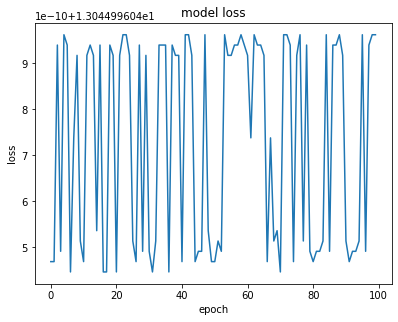

In [36]:
show hist:6#(res[`:history]`)

plt[`:plot]hist`loss;
plt[`:plot]hist`val_loss;
plt[`:title]"model loss";
plt[`:ylabel]"loss";
plt[`:xlabel]"epoch";
plt[`:show][];

0| 23085 2640
1| 0     0   


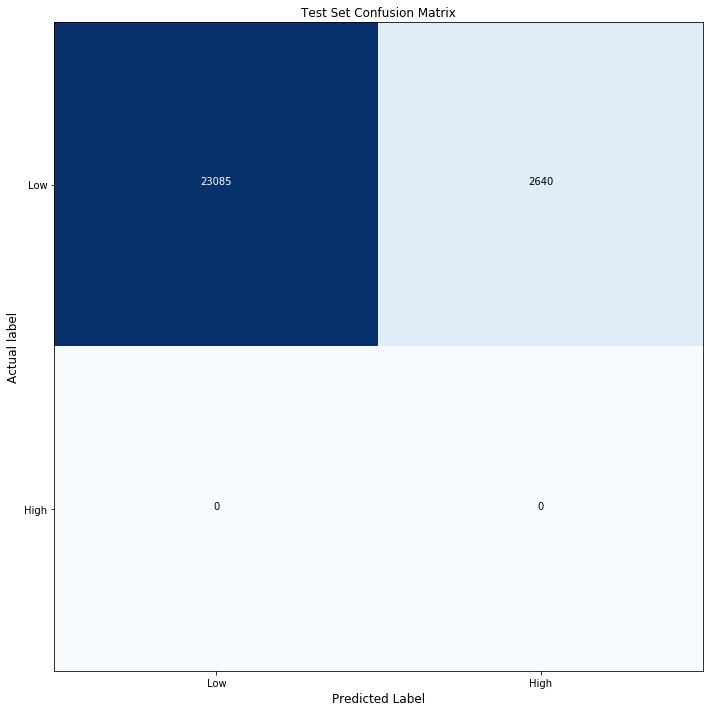

In [37]:
show cnfM:.ml.confmat[ytest;0.5>nnPred]
.ml.displayCM[value cnfM;`Low`High;"Test Set Confusion Matrix";()]